In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rectangle import Rectangle
from sklearn.linear_model import LinearRegression
import utility
from itertools import combinations
import math

In [2]:
def make_2D_score_plot(scores, dimx, dimy, ax = None, figsize=(8, 8), limits = None):
    """
    Create a 2D scatter plot for a specific pair of dimensions.

    Parameters
    ----------
    scores : numpy.ndarray
        Matrix of shape (n_samples, n_features) representing the data to plot.
    dimx : int
        Index of the dimension for the x-axis.
    dimy : int
        Index of the dimension for the y-axis.
    figsize : tuple, optional
        Size of the figure in inches. Default: (8, 8).

    Returns
    -------
    tuple
        fig, ax : matplotlib Figure and Axes object.
    """

    n = scores.shape[1]
    if not (0 <= dimx < n and 0 <= dimy < n):
        raise ValueError(f"dimx={dimx} or dimy={dimy} out of range for {n}-dimensional data.")
    if dimx == dimy:
        raise ValueError("dimx and dimy must be different to form a valid 2D projection.")

    scores_transpose = np.transpose(scores)
    if limits is None:
        limits = np.max(scores[:, [dimx, dimy]], axis = 0)*1.1

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.scatter(scores_transpose[dimx], scores_transpose[dimy], s=1)
        ax.set_xlim(0, limits[0])
        ax.set_ylim(0, limits[1])
        ax.set_aspect('equal', adjustable = "box")
        ax.set_xlabel(f"Dimension {dimx}")
        ax.set_ylabel(f"Dimension {dimy}")
        ax.set_title(f"Projection on dims ({dimx}, {dimy})")
        plt.tight_layout()
        return fig, ax
    
    ax.scatter(scores_transpose[dimx], scores_transpose[dimy], s=1)
    ax.set_xlim(0, limits[0])
    ax.set_ylim(0, limits[1])
    ax.set_aspect('equal')
    ax.set_xlabel(f"Dimension {dimx}")
    ax.set_ylabel(f"Dimension {dimy}")
    ax.set_title(f"Projection on dims ({dimx}, {dimy})")
    plt.tight_layout()

def make_score_plot(scores, global_limit = True):
    """
    Create scatter plots of pairwise dimensions of vectorized scores.

    Parameters
    ----------
    scores : numpy.ndarray
        Matrix of shape (n_samples, n_features) representing the data to plot.
    dimx : int, optional
        Index of the dimension for the x-axis. Default: None (all pairs).
    dimy : int, optional
        Index of the dimension for the y-axis. Default: None (all pairs).
    figsize : tuple, optional
        Size of the figure in inches. Default: (12, 12).

    Returns
    -------
    tuple
        fig, axes : matplotlib Figure and Axes object(s).
    """

    n = scores.shape[1]
    scores_transpose = np.transpose(scores)
    # All pairwise projections
    dim_pairs = list(combinations(range(n), 2))  # Unique pairs of dimensions
    num_pairs = len(dim_pairs)

    # Determine grid layout
    cols = min(3, num_pairs)
    rows = math.ceil(num_pairs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), squeeze=False)
    axes = axes.flatten()  # Flatten for easy iteration

    for idx, (dx, dy) in enumerate(dim_pairs):
        if global_limit:
            global_limits = [np.max(scores) * 1.1, np.max(scores) * 1.1]
            make_2D_score_plot(scores, dx, dy, axes[idx], limits = global_limits)
        else:
            make_2D_score_plot(scores, dx, dy, axes[idx])

    # Hide unused subplots
    for idx in range(num_pairs, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    return fig, axes

In [3]:
def scale_with_sampling(scores, rectangle, random_state=42):
    """
    Scales scores by appending a randomly sampled point from a rectangle region.

    Parameters
    ----------
    scores : numpy.ndarray
        2D array of shape (n_samples, n_features) containing the original scores.
    rectangle : Rectangle
        Defines the sampling range with `lower` and `upper` bounds.
    random_state : int, optional
        Seed for the random number generator.

    Returns
    -------
    tuple
        - Scaled scores as a 2D numpy array.
        - Standard deviation of the scaled data along each feature.
    """
    np.random.seed(random_state)

    lower, upper = rectangle.lower, rectangle.upper

    sampled_point = np.random.uniform(lower, upper, size=(1, scores.shape[1]))
    scores_new = np.append(scores, sampled_point, axis=0)
    
    std_dev = np.std(scores_new, axis=0)
    scaled_scores = scores / std_dev
    
    return scaled_scores, std_dev

def compute_prediction_region(scores, alpha, rect_to_scale):
    """
    Scales scores and computes a prediction region using the quantile threshold.
    
    Parameters
    ----------
    scores : numpy.ndarray
        Array of input scores.
    alpha : float
        Significance level for quantile computation.
    rect_to_scale : Rectangle
        Rectangle for scaling operations.

    Returns
    -------
    Rectangle
        A rectangle representing the prediction region.
    """
    scores_scaled, scale = scale_with_sampling(scores, rect_to_scale)
    max_norm_scaled = np.max(scores_scaled, axis=1)

    n = len(scores)
    quantile_level = math.ceil((1 - alpha) * (n + 1)) / n
    quantile_val = np.quantile(max_norm_scaled, quantile_level)

    return Rectangle(quantile_val * scale)


def reorder_dimensions_by_variance(scores_transpose):
    """
    Reorders scores by decreasing variance along each dimension.
    
    Parameters
    ----------
    scores_transpose : numpy.ndarray
        Transposed scores array (features as rows).
    
    Returns
    -------
    numpy.ndarray
        Reordered scores.
    """
    variances = np.var(scores_transpose, axis=1)
    sorted_indices = np.argsort(variances)[::-1]
    return scores_transpose[sorted_indices, :]


def scores_completion_sorted(scores, descending = True):
    """
    Completes scores with additional points for prediction region computations.
    
    Parameters
    ----------
    scores : numpy.ndarray
        Original scores array.
    
    Returns
    -------
    numpy.ndarray
        Sorted and augmented scores.
    """
    unique_scores = np.unique(scores, axis=0)
    max_point = np.max(scores, axis=0) * 1.2
    augmented_scores = np.append(unique_scores, [max_point, np.zeros_like(max_point)], axis=0)
    if descending:
        return -np.sort(-augmented_scores, axis=0, kind="mergesort")
    return np.sort(augmented_scores, axis=0, kind="mergesort")

In [65]:
def one_rect_prediction_regions_nD(scores, alpha, short_cut = True):

    # Sort the transposed scores from smallest to largest coordinate-wise 
    scores_sorted = np.transpose(utility.scores_completion_sorted(scores, False))
    
    # Number of samples, number of dimensions, conformal index
    n = scores.shape[0]
    d = scores.shape[1]
    level = math.ceil((1 - alpha) * (n + 1))

    def create_hyper_rectangle(indices):

        upper = [scores_sorted[dim][indices[dim]] for dim in range(d)]
        lower = [scores_sorted[dim][indices[dim]-1] for dim in range(d)]

        return Rectangle(upper, lower)
    
    def binary_search_dimension(scores_sorted, fixed_indices, dim_along, regions, start, end):
        if start >= end-1:
            indices = np.copy(fixed_indices)
            indices[dim_along] = start
            rectangle = create_hyper_rectangle(indices)
            region = utility.compute_prediction_region(scores, alpha, rectangle)
            if region.intersection(rectangle):
                regions.append(region.intersection(rectangle))
            return

        mid = (start + end) // 2
        indices = np.copy(fixed_indices)
        indices[dim_along] = mid
        rectangle = create_hyper_rectangle(indices)
        region = utility.compute_prediction_region(scores, alpha, rectangle)
        intersection = region.intersection(rectangle)

        if not intersection:
            binary_search_dimension(scores_sorted, fixed_indices, dim_along, regions, start, mid)
        elif intersection.same_as(rectangle):
            binary_search_dimension(scores_sorted, fixed_indices, dim_along, regions, mid, end)
        else:
            #new_lower = [scores_sorted[dim][level] if dim == dim_along else scores_sorted[dim][fixed_indices[dim] - 1] for dim in range(d)]
            regions.append(region.intersection(Rectangle(rectangle.upper)))

    if short_cut:
        scores_mean = np.mean(np.transpose(scores), axis=1)
        abs_diff = np.abs(np.transpose(np.array([scores_mean])) - np.sort(np.transpose(scores), axis=1, kind="mergesort"))
        mask = (np.transpose(np.array([scores_mean])) - np.sort(np.transpose(scores), axis=1, kind="mergesort")) > 0
        abs_diff[mask] = np.inf 
        mean_index = np.argmin(abs_diff, axis=1) + 1
        print(mean_index)
        regions = []
        max_bounds = np.zeros(d)
        for idx in range(d):
            fix_indices = np.copy(mean_index)
            fix_indices[idx] = 1
            binary_search_dimension(scores_sorted, fix_indices, idx, regions, 1, n+1)
            max_bounds = np.maximum(max_bounds, regions[-1].upper)

        return Rectangle(upper=max_bounds)

In [69]:
def full_prediction_regions_3D(scores, alpha, short_cut=True, one_rect=True):
    scores_sorted = np.transpose(utility.scores_completion_sorted(scores, False))
    #scores_sorted = utility.reorder_dimensions_by_variance(np.transpose(scores_modified))
    n = len(scores)
    level = math.ceil((1 - alpha) * (n + 1))

    def create_rectangle(idx, idy, idz):
        length, length_prev = scores_sorted[0][idx], scores_sorted[0][idx - 1]
        height, height_prev = scores_sorted[1][idy], scores_sorted[1][idy - 1]
        depth, depth_prev = scores_sorted[2][idz], scores_sorted[2][idz - 1]
        upper = (length, height, depth)
        lower = (length_prev, height_prev, depth_prev)
        return Rectangle(upper, lower)

    def binary_search_dimension(scores_sorted, fixed_indices, dim, regions, start, end):
        if start >= end-1:
            indices = fixed_indices[:]
            indices[dim] = start
            rectangle = create_rectangle(*indices)
            region = utility.compute_prediction_region(scores, alpha, rectangle)
            if region.intersection(rectangle):
                regions.append(region.intersection(rectangle))
            return

        mid = (start + end) // 2
        indices = fixed_indices[:]
        indices[dim] = mid
        rectangle = create_rectangle(*indices)
        region = utility.compute_prediction_region(scores, alpha, rectangle)
        intersection = region.intersection(rectangle)

        if not intersection:
            binary_search_dimension(scores_sorted, fixed_indices, dim, regions, start, mid)
        elif intersection.same_as(rectangle):
            binary_search_dimension(scores_sorted, fixed_indices, dim, regions, mid, end)
        else:
            new_lower = [scores_sorted[d][level] if d == dim else scores_sorted[d][fixed_indices[d] - 1]
                         for d in range(3)]
            regions.append(region.intersection(Rectangle(rectangle.upper, new_lower)))

    if short_cut:
        scores_mean = np.mean(np.transpose(scores), axis=1)
        mean_index = np.argmin(np.abs(np.transpose(np.array([scores_mean]))-np.sort(np.transpose(scores), axis=1, kind="mergesort")), axis=1)+1
        regions = []
        max_bounds = np.zeros(3)

        # fix depth
        fix_depth = mean_index[2]
        for idy in range(1, n+2):
            fixed_indices = [1, idy, fix_depth]
            binary_search_dimension(scores_sorted, fixed_indices, 0, regions, level, n+1)
            max_bounds = np.maximum(max_bounds, regions[-1].upper)
        for idx in range(1, n+2):
            fixed_indices = [idx, 1, fix_depth]
            binary_search_dimension(scores_sorted, fixed_indices, 1, regions, level, n+1)
            max_bounds = np.maximum(max_bounds, regions[-1].upper)

        # fix height
        fix_height = mean_index[1]
        for idz in range(1, n+2):
            fixed_indices = [1, fix_height, idz]
            binary_search_dimension(scores_sorted, fixed_indices, 0, regions, level, n+1)
            max_bounds = np.maximum(max_bounds, regions[-1].upper)
        for idx in range(1, n+2):
            fixed_indices = [idx, fix_height, 1]
            binary_search_dimension(scores_sorted, fixed_indices, 2, regions, level, n+1)
            max_bounds = np.maximum(max_bounds, regions[-1].upper)

        # fix length
        fix_length = mean_index[0]
        for idy in range(1, n+2):
            fixed_indices = [fix_length, idy, 1]
            binary_search_dimension(scores_sorted, fixed_indices, 2, regions, level, n+1)
            max_bounds = np.maximum(max_bounds, regions[-1].upper)
        for idz in range(1, n+2):
            fixed_indices = [fix_length, 1, idz]
            binary_search_dimension(scores_sorted, fixed_indices, 1, regions, level, n+1)
            max_bounds = np.maximum(max_bounds, regions[-1].upper)

        '''for idx in range(max(1, mean_index[0] - 3), min(n + 1, mean_index[0] + 3)):
            for idy in range(max(1, mean_index[1] - 3), min(n + 1, mean_index[1] + 3)):
                for idz in range(max(1, mean_index[2] - 3), min(n + 1, mean_index[2] + 3)):
                    fixed_indices = [idx, idy, idz]
                    for dim in range(3):
                        binary_search_dimension(scores_sorted, fixed_indices, dim, regions, 1, n + 1)
                        max_bounds[dim] = max(max_bounds[dim], regions[-1].upper[dim])
                        print(max_bounds)'''
        if one_rect:
            return Rectangle(upper=tuple(max_bounds))
        return regions
            

    else:   
        regions = []
        max_bounds = np.zeros(3)
        for idz in range(1, n+2):
            for idy in range(1,n+2):
                for idx in range(1, n+2):
                    
                    rectangle = create_rectangle(idx, idy, idz)
                    
                    region = utility.compute_prediction_region(scores, alpha, rectangle)
                    intersection = region.intersection(rectangle)
                    if intersection:
                            regions.append(intersection)
                            max_bounds = np.maximum(max_bounds, intersection.upper)
        if one_rect:
            return Rectangle(upper=max_bounds)
        return regions

# n=100

In [35]:
df = pd.read_csv("Data/Data3Dnoised1000.csv", index_col=0)
X0 = df.iloc[:,0:20].values
y0 = df[["r1", "r2", "r3"]].values
X0_train, X0_test, X0_cal, y0_train, y0_test, y0_cal = utility.calibration_split(X0, y0)
# Fit model to training
model = LinearRegression()
model.fit(X0_train, y0_train)
# Vectorized calibration scores
prediction0 = model.predict(X0_cal)
scores0 = np.abs(prediction0 - y0_cal)

# Test scores
prediction_test0 = model.predict(X0_test)
scores_test0 = np.abs(prediction_test0 - y0_test)

## Full intersection

In [28]:
# Original method
#regions0 = full_prediction_regions_3D(scores0, 0.1, short_cut=False, one_rect=False)
#print(f"Scores coverage: {utility.check_coverage_rate(scores0, regions0, one_rect=False)}\nTesting scores coverage: {utility.check_coverage_rate(scores_test0, regions0, one_rect=False)}")
region0 = full_prediction_regions_3D(scores0, 0.1, short_cut=False)
print(f"Scores coverage: {utility.check_coverage_rate(scores0, region0)}\nTesting scores coverage: {utility.check_coverage_rate(scores_test0, region0)}")

Scores coverage: 0.92
Testing scores coverage: 0.92


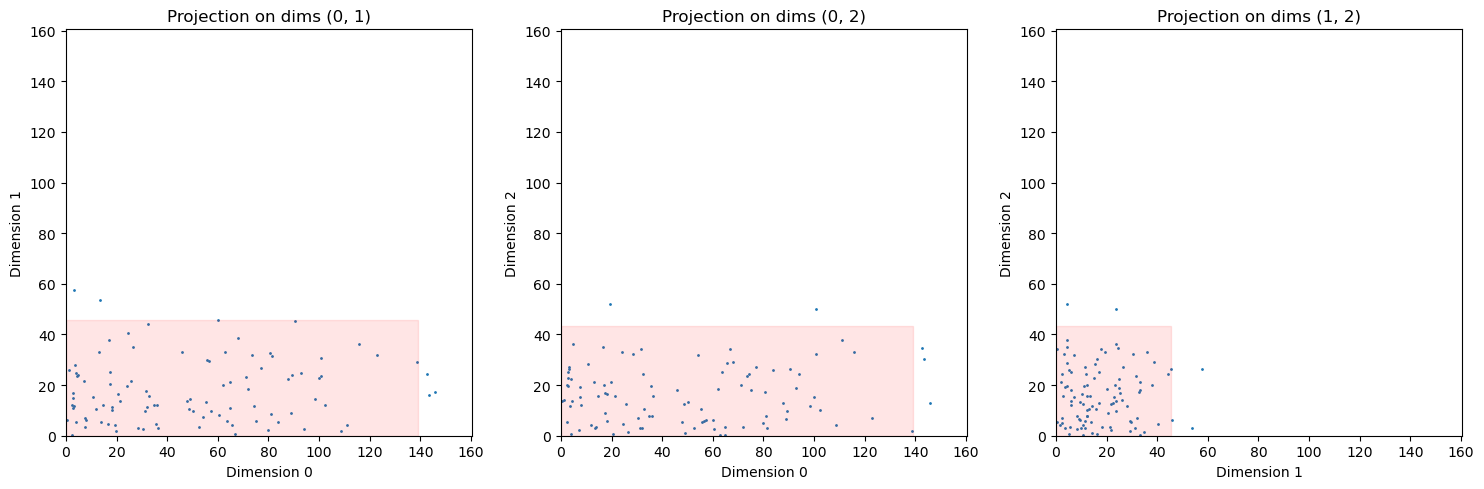

In [29]:
fig, axes = make_score_plot(scores0)
#for region in regions0:
    #region.draw_2D(axes[0], 0, 1)
    #region.draw_2D(axes[1], 0, 2)
    #region.draw_2D(axes[2], 1, 2)
region0.draw_2D(axes[0], 0, 1)
region0.draw_2D(axes[1], 0, 2)
region0.draw_2D(axes[2], 1, 2)

## Shortcut

In [66]:
Region0 = full_prediction_regions_3D(scores0, 0.1)
print(f"Scores coverage: {utility.check_coverage_rate(scores0, Region0)}\nTesting scores coverage: {utility.check_coverage_rate(scores_test0, Region0)}")

Scores coverage: 0.92
Testing scores coverage: 0.92


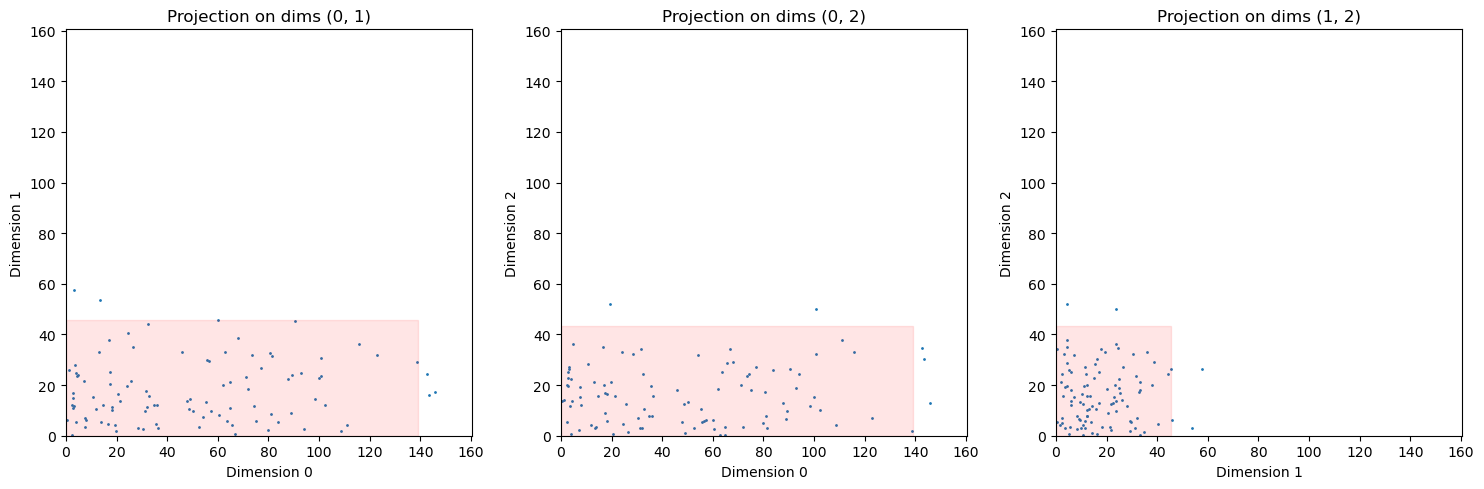

In [33]:
fig, axes = make_score_plot(scores0)
#for region in regions0:
    #region.draw_2D(axes[0], 0, 1)
    #region.draw_2D(axes[1], 0, 2)
    #region.draw_2D(axes[2], 1, 2)
Region0.draw_2D(axes[0], 0, 1)
Region0.draw_2D(axes[1], 0, 2)
Region0.draw_2D(axes[2], 1, 2)

## Comparison

In [67]:
Region0.info()

array([[  0.        ,   0.        ,   0.        ],
       [139.07417092,  45.53303636,  43.17702047]])

In [68]:
region0.info()

array([[  0.        ,   0.        ,   0.        ],
       [139.07417092,  45.53303636,  43.17702047]])